In [42]:
import matplotlib
import pandas as pd
import seaborn as sns

results = pd.read_csv('./questionnaire-results.tsv', '\t')

In [43]:
# Functions to select entries with a given job from the dataset
# Choices in the questionnaire were :
# 'Architecte et développeur', 'Développeur', 'Architecte', 'Consultant'

def select_entries_with_job(results, selected_names, notin = False):
    results_with_job_in_selected_names = results[results.columns[2]].isin(selected_names)
    cond = ~results_with_job_in_selected_names if notin else results_with_job_in_selected_names
    return results.loc[cond]


def architects(results):
    return select_entries_with_job(results, ['Architecte'])

def developers(results):
    return select_entries_with_job(results, ['Développeur'])

def both_architect_and_developers(results):
    return select_entries_with_job(results, ['Architecte et développeur', 'CTO'])

def consultants(results):
    return select_entries_with_job(results, ['Consultant', 'Consultant architecte'])

def other_jobs(results):
    return select_entries_with_job(results, ['Architecte et développeur', 'CTO', 'Développeur', 'Architecte', 'Consultant', 'Consultant architecte'], True)

In [44]:
# Functions to select entries with a given number of VM from the dataset
# Choices in the questionnaire were :
# 'Moins de 100', 'Entre 100 et 500', 'Entre 500 et 1000', 'Entre 1000 et 3000', 'Plus de 3000', 'Je ne sais pas'

def select_entries_with_vm(results, number_of_vm, notin = False):
    results_with_selected_number_of_vm = results[results.columns[4]] == number_of_vm
    cond = ~results_with_selected_number_of_vm if notin else results_with_selected_number_of_vm
    return results.loc[cond]


def lt_100_vm(results):
    return select_entries_with_vm(results, 'Moins de 100')

def bt_100_and_500_vm(results):
    return select_entries_with_vm(results, 'Entre 100 et 500')

def bt_500_and_1000_vm(results):
    return select_entries_with_vm(results, 'Entre 500 et 1000')

def bt_1000_and_3000_vm(results):
    return select_entries_with_vm(results, 'Entre 1000 et 3000')

def mt_3000_vm(results):
    return select_entries_with_vm(results, 'Plus de 3000')

def dont_know_vm(results):
    return select_entries_with_vm(results, 'Je ne sais pas')

In [ ]:
populations_roles = {
    'All': len(results),
    'Architects': len(architects(results)),
    'Developers': len(developers(results)),
    'Archi & Devs': len(both_architect_and_developers(results)),
    'Consultants': len(consultants(results)),
    'Others': len(other_jobs(results))
}

population_vm = {
    '< 100': len(lt_100_vm(results)),
    '100 < n < 500': len(bt_100_and_500_vm(results)),
    '500 < n < 1k': len(bt_500_and_1000_vm(results)),
    '1k < n < 3k': len(bt_1000_and_3000_vm(results)),
    '> 3k': len(mt_3000_vm(results)),
    'Don\'t know': len(dont_know_vm(results))
}

population_roles_df = pd.DataFrame(data=populations_roles)
population_vm_df = pd.DataFrame(data=population_vm)
# todo : generate table with populations

In [291]:
def flatten_results(entries):
    series = entries.copy().str.split('; ').apply(pd.Series).unstack().dropna().reset_index(drop=True)
    return series.rename(entries.name)

def with_percentage_series_size(series):
    return with_percentage(series, len(series))

def with_percentage_respondants(series, respondants_count):
    return with_percentage(series, respondants_count)
    
def with_percentage(series, sample_size):
    df = series.to_frame(series.name)
    df['percentage'] = df.groupby([series.name])[series.name].transform(lambda x: len(x)) / sample_size * 100
    return df.drop_duplicates().reset_index()

In [335]:
# Utility functions to display data

def barplot_percentage(data, question, title_suffix, hue=None, col=None, with_percentage=True):
    g = sns.barplot(x='percentage', y=question, data=data, palette = 'Greys', hue=hue)
    g.set_title(question + str(title_suffix))
    g.set_ylabel(None)
    g.set_xbound(upper=max(data.percentage) + 10)
    
    if with_percentage:
        for i, row in data.iterrows():
            g.text(row.percentage + 1, i + 0.1, '{0:.2f}%'.format(round(row.percentage,2)))
        
    return g

def catplot_percentage(data, question, col):
    g = sns.catplot('percentage', question, data=data, col=col, kind='bar', col_wrap=2, palette = 'Greys')
    for (i, axes) in enumerate(g.axes):
        axes.set_ylabel(None)
    return g

In [293]:
studied_data_set = results
# print(studied_data_set)

print('The number of respondant in the data set that is being studied is: ' + str(studied_data_set[studied_data_set.columns[0]].size))

The number of respondant in the data set that is being studied is: 53


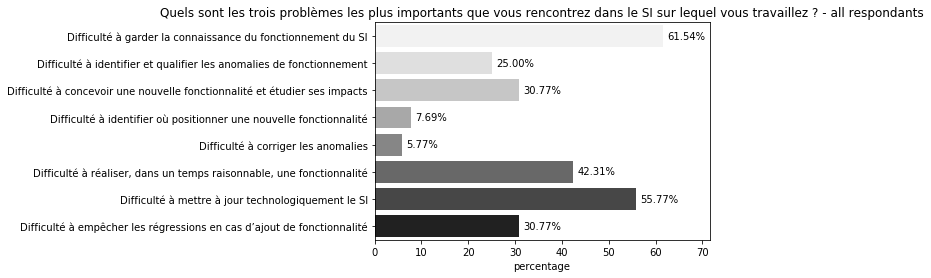

In [325]:
question = studied_data_set.columns[5]

def clean_dataset_for_major_problems(source):
    question = studied_data_set.columns[5]
    dataset = source[question].dropna()
    return with_percentage_respondants(flatten_results(dataset), len(dataset))

major_problems = clean_dataset_for_major_problems(studied_data_set)

g = barplot_percentage(major_problems, question, ' - all respondants')

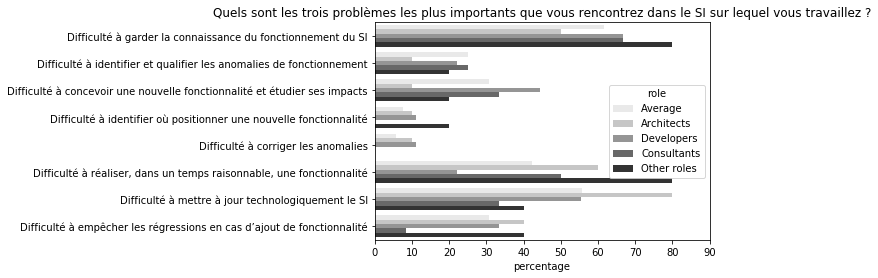

In [316]:
question = studied_data_set.columns[5]

major_problems_overall = clean_dataset_for_major_problems(results)
major_problems_overall['role'] = 'Average'
major_problems_archi = clean_dataset_for_major_problems(architects(results))
major_problems_archi['role'] = 'Architects'
major_problems_dev = clean_dataset_for_major_problems(developers(results))
major_problems_dev['role'] = 'Developers'
major_problems_consultants = clean_dataset_for_major_problems(consultants(results))
major_problems_consultants['role'] = 'Consultants'
major_problems_others = clean_dataset_for_major_problems(other_jobs(results))
major_problems_others['role'] = 'Other roles'

major_problems = pd.concat([major_problems_overall, major_problems_archi, major_problems_dev, major_problems_consultants, major_problems_others])


g = barplot_percentage(major_problems, question, hue='role', with_percentage=False)

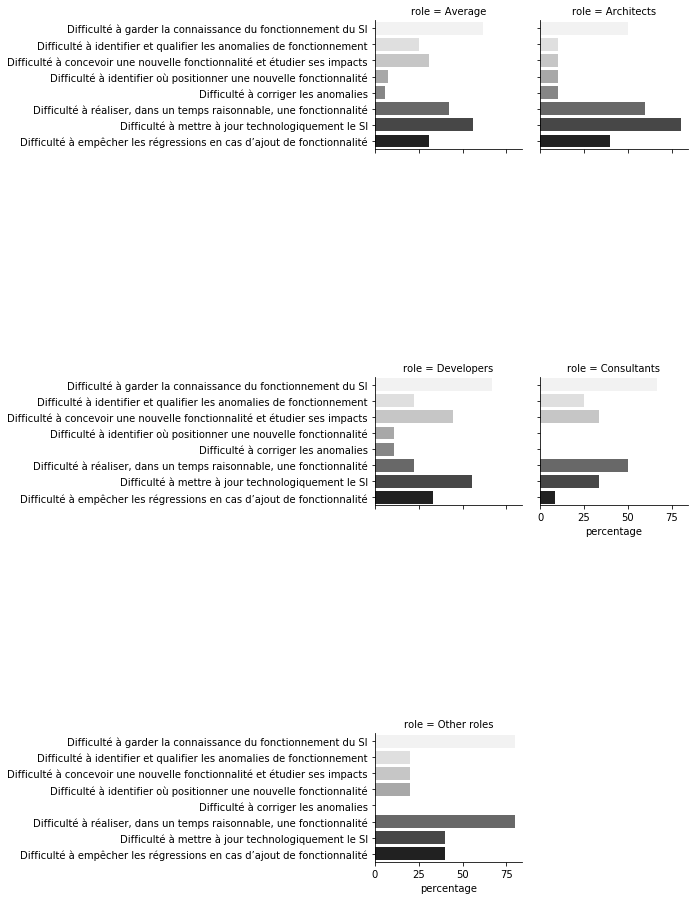

In [336]:
question = studied_data_set.columns[5]

major_problems_overall = clean_dataset_for_major_problems(results)
major_problems_overall['role'] = 'Average'
major_problems_archi = clean_dataset_for_major_problems(architects(results))
major_problems_archi['role'] = 'Architects'
major_problems_dev = clean_dataset_for_major_problems(developers(results))
major_problems_dev['role'] = 'Developers'
major_problems_consultants = clean_dataset_for_major_problems(consultants(results))
major_problems_consultants['role'] = 'Consultants'
major_problems_others = clean_dataset_for_major_problems(other_jobs(results))
major_problems_others['role'] = 'Other roles'

major_problems = pd.concat([major_problems_overall, major_problems_archi, major_problems_dev, major_problems_consultants, major_problems_others])

g = catplot_percentage(major_problems, question, 'role')